In [1]:
from typing import Tuple
import pandas as pd
from tqdm import tqdm
import os
import time
import random
import pickle
import numpy as np
from os.path import isfile, join
from pydub import AudioSegment
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import librosa

import torch
from torch import nn
from torchaudio import transforms

from models.audio_LSTMCNN import AudioLSTMCNN, AudioLSTMCNN2
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Constants

In [2]:
RATE = 44100
MEL_SPECTROGRAM_BUCKETS = 128
MEL_SPECTROGRAM_WINDOW_LENGTH = 224
SPECTROS_PER_SECOND = RATE // (MEL_SPECTROGRAM_WINDOW_LENGTH / 2) - 1
CHUNKS_PER_SECOND = 2
CHUNK_SIZE_IN_SPECTROS = int(SPECTROS_PER_SECOND // CHUNKS_PER_SECOND)

TRAINSET_RATIO = 0.8

In [3]:
CHUNK_SIZE_IN_SPECTROS

196

In [4]:
def get_quadrant(val: float, aro: float) -> int:
    if val >= 0.5 and aro >= 0.5:
        return 1
    if val >= 0.5 and aro < 0.5:
        return 2
    if val < 0.5 and aro < 0.5:
        return 3
    if val < 0.5 and aro >= 0.5:
        return 4

<hr>

# Dataset

## Create dataset

#### Load data

In [5]:
AUDIO_FOLDER = "C:\\Users\\amity\\PycharmProjects\\aimpathy\\data\\PMEmo\\PMEmo2019\\chorus"
THAYER_ANOTATIONS_CSV = "C:\\Users\\amity\\PycharmProjects\\aimpathy\\data\\PMEmo\\PMEmo2019\\annotations\\dynamic_annotations.csv"
thayer_annotations_df = pd.read_csv(THAYER_ANOTATIONS_CSV)

In [6]:
audio_files = [f for f in os.listdir(AUDIO_FOLDER) if isfile(join(AUDIO_FOLDER, f))]
audio_data = dict()
torch_spectorgrams = dict()
spectrogrammer = transforms.MelSpectrogram(sample_rate=RATE, n_fft=(MEL_SPECTROGRAM_BUCKETS * 2 - 2), win_length=MEL_SPECTROGRAM_WINDOW_LENGTH, power=2, normalized=True)

C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\torchaudio\functional\functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (128) may be set too low.
  warnings.warn(


#### Convert to Spectrograms

In [7]:
spectrograms = dict()
for audio_file in tqdm(audio_files, total=len(audio_files)):
    sound = AudioSegment.from_mp3(os.sep.join([AUDIO_FOLDER, audio_file])).set_channels(1)
    audio_file_wave = sound.export(format="wav", bitrate=RATE)
    sample_rate, samples = wavfile.read(audio_file_wave)
    spectogram = spectrogrammer(torch.from_numpy(samples/(2**15)).float().reshape((1, -1)))
    spectrograms[audio_file] = spectogram
    audio_file_wave.close()
spectrograms = {key: value for key, value in spectrograms.items() if ".wav" not in key}

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [03:18<00:00,  4.01it/s]


#### Create final dataset

In [8]:
dataset = dict()  # music_id: spectrogram, (valence, arousal)
for file_name, spectrogram in tqdm(spectrograms.items(), total=len(spectrograms)):
    music_id = int(file_name.replace(".mp3", ""))
    dataset[music_id] = list()
    max_frame_time = thayer_annotations_df[thayer_annotations_df["musicId"] == music_id]["frameTime"].max()
    if np.isnan(max_frame_time):    
        dataset.pop(music_id)
        continue
    for i in range(int(CHUNKS_PER_SECOND * max_frame_time)):
        data_df = thayer_annotations_df[(thayer_annotations_df["musicId"] == music_id) & (thayer_annotations_df["frameTime"] == i/2)]
        if data_df.empty:
            #  print(f"Skipping {musicI_id} - {i/2}")
            continue
        valence = data_df.iloc[0]["Valence(mean)"]
        arousal = data_df.iloc[0]["Arousal(mean)"]
        dataset[music_id].append((spectrogram[0, :, int((i/2-1)*CHUNK_SIZE_IN_SPECTROS): int((i/2)*CHUNK_SIZE_IN_SPECTROS)], (valence, arousal)))
    
    if len(dataset[music_id]) <= 0:
        dataset.pop(music_id)
        
music_id_to_quadrant = {key: get_quadrant(np.mean([val[1][0] for val in value]), np.mean([val[1][1] for val in value])) for key, value in dataset.items() if value}
quadrant_counters = [list(music_id_to_quadrant.values()).count(i+1) for i in range(4)]
quadrant_ratios = max(quadrant_counters)//np.array(quadrant_counters)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 793/793 [00:31<00:00, 25.37it/s]


### Divide to train and test

In [9]:
train_music_ids = random.sample(dataset.keys(), int(TRAINSET_RATIO*len(dataset)))
trainset = {key: value for key, value in dataset.items() if key in train_music_ids}
testset = {key: value for key, value in dataset.items() if key not in train_music_ids}

In [10]:
with open(f'data/datasets/trainset_{int(time.time())}.pk', 'wb') as f:
    pickle.dump(list(trainset.keys()), f)
with open(f'data/datasets/testset_{int(time.time())}.pk', 'wb') as f:
    pickle.dump(list(testset.keys()), f)

### Load train and test

In [ ]:
dataset_label = '1675258188'
with open(f'data/datasets/trainset_{dataset_label}.pk', 'rb') as f:
    trainset_ids = pickle.load(f)
    trainset = {key: value for key, value in dataset.items() if key in trainset_ids}
with open(f'data/datasets/testset_{dataset_label}.pk', 'rb') as f:
    testset_ids = pickle.load(f)
    testset = {key: value for key, value in dataset.items() if key in testset_ids}

In [11]:
trainset_quadrant_to_keys = dict()

for music_id in trainset.keys():
    quad = music_id_to_quadrant[music_id]
    if quad not in trainset_quadrant_to_keys:
        trainset_quadrant_to_keys[quad] = list()
    trainset_quadrant_to_keys[quad].append(music_id)

## Plot spectrogram

In [ ]:
import matplotlib.pyplot as plt
import librosa

In [ ]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None, ymax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    if ymax:
        axs.set_ylim((0, ymax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
plot_spectrogram(dataset[1000][100][0], title="Mel-scale Spectrogram", ylabel="mel freq")

# Model

### Load model

In [ ]:
model_name = f'saved_models/AudioLSTMCNN2_1675359498_016237589488721192.pt'
model_c = AudioLSTMCNN()
model_c.load_state_dict(torch.load(model_name));
model_c.eval().cuda()
print("Loaded model")

### Train model

In [71]:
model_c = AudioLSTMCNN2().cuda()

In [72]:
LEARNING_RATE = 0.0001

In [73]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model_c.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3, factor=0.5)

In [74]:
start_time = time.time()
EPOCS = 6
PRINT_MARK = 500
BATCH_SIZE = 50
STOP_LOSS = 0.01
MIN_LEARNING_RATE = 0.000001


model_c.train()
model_c.hidden = (model_c.hidden[0].cuda(), model_c.hidden[1].cuda())
for epoc in range(EPOCS):
    losses = list()
    quadrants = list()
    real_quadrants = list()
    train_key_sample = [key for keys in [random.sample(trainset_quadrant_to_keys[i+1], BATCH_SIZE//4) for i in range(4)] for key in keys]
    random.shuffle(train_key_sample)
    train_sample = [datum for sample_key in train_key_sample for datum in trainset[sample_key]]
    
    for batch_i, (X_train, (valence, arousal)) in enumerate(train_sample):
        model_c.hidden = tuple([each.data for each in model_c.hidden])
#         model_c.hidden = (torch.zeros(model_c.hidden[0].shape).cuda(),
#                           torch.zeros(model_c.hidden[0].shape).cuda())

        optimizer.zero_grad()
        
        y_train = torch.Tensor((valence, arousal)).cuda()
        # Apply the model
        y_pred = model_c(X_train.cuda())  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)

        # Update parameters
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.cpu().item())
        real_quadrants.append(get_quadrant(y_train[0].item(), y_train[1].item()))
        quadrants.append(get_quadrant(y_pred[0].item(), y_pred[1].item()))
        
        # Print interim results
        if (batch_i > 0 or epoc == 0) and batch_i%PRINT_MARK == 0:
            print(f'{epoc:2}-{batch_i:4} | loss: {np.mean(losses):.5f}  |  [{quadrants.count(1):4}({real_quadrants.count(1):4}), {quadrants.count(2):4}({real_quadrants.count(2):4}), {quadrants.count(3):4}({real_quadrants.count(3):4}), {quadrants.count(4):4}({real_quadrants.count(4):4})]     lr: {optimizer.param_groups[0]["lr"]}')
    
    scheduler.step(np.mean(losses))

    if np.mean(losses) < STOP_LOSS or optimizer.param_groups[0]["lr"] < MIN_LEARNING_RATE:
        break
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

 0-   0 | loss: 0.16111  |  [   0(   0),    0(   0),    1(   0),    0(   1)]     lr: 0.0001
 0- 500 | loss: 0.03283  |  [ 168( 217),   71(  83),  187(  57),   75( 144)]     lr: 0.0001
 0-1000 | loss: 0.02853  |  [ 333( 348),  183( 276),  354(  81),  131( 296)]     lr: 0.0001
 0-1500 | loss: 0.02834  |  [ 489( 523),  292( 407),  504( 180),  216( 391)]     lr: 0.0001
 0-2000 | loss: 0.02439  |  [ 576( 601),  385( 529),  809( 328),  231( 543)]     lr: 0.0001
 1- 500 | loss: 0.01711  |  [ 144( 104),  107( 207),  213( 106),   37(  84)]     lr: 0.0001
 1-1000 | loss: 0.02364  |  [ 324( 318),  131( 213),  378( 240),  168( 230)]     lr: 0.0001
 1-1500 | loss: 0.02103  |  [ 433( 405),  241( 371),  588( 324),  239( 401)]     lr: 0.0001
 1-2000 | loss: 0.02151  |  [ 550( 508),  245( 371),  879( 603),  327( 519)]     lr: 0.0001
 1-2500 | loss: 0.02269  |  [ 729( 667),  280( 500), 1077( 687),  415( 647)]     lr: 0.0001
 2- 500 | loss: 0.01569  |  [ 145( 117),  180( 212),   62(   9),  114( 163)]    

In [75]:
latest_model_name = f'saved_models/AudioLSTMCNN2_(lr-{str(LEARNING_RATE)}_epocs-{str(epoc)}_bs-{str(BATCH_SIZE)})_{int(time.time())}_{str(round(np.mean(losses[2:]), 3))}.pt'
torch.save(model_c.state_dict(), latest_model_name)
print(f"Saved model {latest_model_name}")

Saved model saved_models/AudioLSTMCNN2_(lr-0.0001_epocs-5_bs-50)_1675603383_0.021.pt


### Test model

In [90]:
losses = list()
quadrants = list()

model_c.eval().cuda()
with torch.no_grad():
    model_c.hidden = (model_c.hidden[0].cuda(), model_c.hidden[1].cuda())
    test_sample = [datum for key, value in testset.items() for datum in value]
    for batch_i, (X_test, (valence, arousal)) in tqdm(enumerate(test_sample), total=len(test_sample)):
        y_test = torch.Tensor((valence, arousal)).cuda()
        model_c.hidden = tuple([each.data for each in model_c.hidden])
        # Apply the model
#         model_c.hidden = (torch.zeros(model_c.hidden[0].shape).cuda(),
#                           torch.zeros(model_c.hidden[0].shape).cuda())
        
        y_val = model_c(X_test.cuda())
        loss = criterion(y_val, y_test)
        losses.append(loss.cpu())
        quadrants.append((get_quadrant(y_val[0].item(), y_val[1].item()), get_quadrant(y_test[0].item(), y_test[1].item())))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7431/7431 [00:25<00:00, 290.37it/s]


In [91]:
print(f"Mean: {np.mean(losses):.5f}, median: {np.median(losses):.5f}")

Mean: 0.04508, median: 0.03925


In [92]:
print(confusion_matrix([a[0] for a in quadrants], [a[1] for a in quadrants]))
print("\n")
print(classification_report([a[0] for a in quadrants], [a[1] for a in quadrants]))

[[   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [5022  500  962  947]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.13      0.23      7431

    accuracy                           0.13      7431
   macro avg       0.25      0.03      0.06      7431
weighted avg       1.00      0.13      0.23      7431



C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Inspect quadrants

In [ ]:
testset.keys()

In [ ]:
test_index = 519
test_location = 0

with torch.no_grad():
    pred = model_c(testset[test_index][test_location][0].cuda()).cpu()
print(pred)
print([denormalize(a.item()) for a in pred])
print(testset[test_index][test_location][1])

In [ ]:
[(key, value[0][1]) for key, value in testset.items() if value and value[0][1] < (0.5, 0.5)]

## Random results classifier

#### Random vs. testset

In [ ]:
losses = list()

test_sample = [datum for key, value in testset.items() for datum in value]
for batch_i, (X_test, (valence, arousal)) in tqdm(enumerate(test_sample), total=len(test_sample)):
    y_test = torch.Tensor((valence, arousal)).cuda()
    y_val = torch.Tensor((random.random(), random.random())).cuda()
    loss = criterion(y_val, y_test)
    losses.append(loss.cpu())

In [ ]:
print(f"Mean: {np.mean(losses):.5f}, median: {np.median(losses):.5f}")

#### Random vs. Random

In [ ]:
losses = list()

test_sample = [datum for key, value in testset.items() for datum in value]
for batch_i, (X_test, (valence, arousal)) in tqdm(enumerate(test_sample), total=len(test_sample)):
    y_test = torch.Tensor((random.random(), random.random())).cuda()
    y_val = torch.Tensor((random.random(), random.random())).cuda()
    loss = criterion(y_val, y_test)
    losses.append(loss.cpu())

In [ ]:
print(f"Mean: {np.mean(losses):.5f}, median: {np.median(losses):.5f}")

<hr>

# Research machine factors

In [23]:
def get_spectograms(file_name: str):
    sample_rate, samples = wavfile.read(os.sep.join(["data", "test_audio", file_name]))
    spectrogram = spectrogrammer(torch.from_numpy(samples/(2**15)).float().reshape((1, -1)))
    audio_file_wave.close()
    chunked_spectograms = [spectrogram[0, :, int((i/2-1)*CHUNK_SIZE_IN_SPECTROS): int((i/2)*CHUNK_SIZE_IN_SPECTROS)] for i in range(spectrogram.shape[2]//CHUNK_SIZE_IN_SPECTROS)]
    return chunked_spectograms

In [24]:
def test_spectrograms(spetrograms_to_test, use_memory = True, print_progress = False):
    valence_values = list()
    arousal_values = list()

    with torch.no_grad():
        model_c.hidden = (model_c.hidden[0].cuda(), model_c.hidden[1].cuda())
        for ind, X_test in tqdm(enumerate(spetrograms_to_test), total=len(spetrograms_to_test), disable=not print_progress):
            if X_test.shape[1] < CHUNK_SIZE_IN_SPECTROS:
                valence_values.append(None)
                arousal_values.append(None)
                continue
            
            if use_memory:
                model_c.hidden = tuple([each.data for each in model_c.hidden])
            else:
                model_c.hidden = (torch.zeros(model_c.hidden[0].shape).cuda(),
                                  torch.zeros(model_c.hidden[0].shape).cuda())
                
            y_val = model_c(X_test.cuda())
            valence_values.append(y_val[0].item())
            arousal_values.append(y_val[1].item())
    
    return valence_values, arousal_values

In [25]:
def note_to_freq(note, concert_A=440.0):
    return (2.0 ** ((note - 69) / 12.0)) * concert_A

In [33]:
def plot_thayer_model(valence_values, arousal_values, title, line_labels, x_values = None, x_label = None):
    x_label = x_label if x_label else 'Time [sec]'
    fig, axes = plt.subplot_mosaic("A;B", figsize=(20, 15))
    ax_valence, ax_arousal = axes.values()
    ax_valence.set_title(f'Valence - {title}')
    ax_valence.set_xlabel(x_label)
    ax_valence.set_ylabel('Valence')
#     ax_valence.set_ylim(0, 1)
#     ax_valence.set_xlim(0, 1)
    for ind, valence_value in enumerate(valence_values):
        x_values = list(range(len(valence_value))) if not x_values else x_values
        valence_line, = ax_valence.plot(x_values, valence_value, '-', lw=2, alpha=0.5)
        valence_line.set_label(line_labels[ind])
        
    ax_valence.legend()

    ax_arousal.set_title(f'Arousal - {title}')
    ax_arousal.set_xlabel(x_label)
    ax_arousal.set_ylabel('Arousal')
#     ax_arousal.set_ylim(0, 1)
#     ax_arousal.set_xlim(0, 1)
    for ind, arousal_value in enumerate(arousal_values):
        x_values = list(range(len(arousal_value))) if not x_values else x_values
        arousal_line, = ax_arousal.plot(x_values, arousal_value, '-', lw=2, alpha=0.5)
        arousal_line.set_label(line_labels[ind])
    
    ax_arousal.legend()

In [59]:
model_c.eval().cuda()
print("In EVAL mode")

In EVAL mode


### Scales

In [93]:
scale_down_files = ["chromatic_8_scale_down"]  # ["chromatic_scale_down", "chromatic_double_scale_down", "chromatic_4_scale_down", "chromatic_8_scale_down"]
scale_up_files = ["chromatic_8_scale_up"]  # ["chromatic_scale_up", "chromatic_double_scale_up", "chromatic_4_scale_up", "chromatic_8_scale_up"]

In [94]:
scale_down_results = dict()
scale_up_results = dict()

for test_file in scale_down_files:
    scale_down_results[test_file] = dict()
    for use_memory in [True, False]:
        spectrograms = get_spectograms(f"{test_file}.wav")
        valence_values, arousal_values = test_spectrograms(spectrograms, use_memory=use_memory)
        scale_down_results[test_file][use_memory] = (valence_values, arousal_values)

        
for test_file in scale_up_files:
    scale_up_results[test_file] = dict()
    for use_memory in [True, False]:
        spectrograms = get_spectograms(f"{test_file}.wav")
        valence_values, arousal_values = test_spectrograms(spectrograms, use_memory=use_memory)
        scale_up_results[test_file][use_memory] = (valence_values, arousal_values)

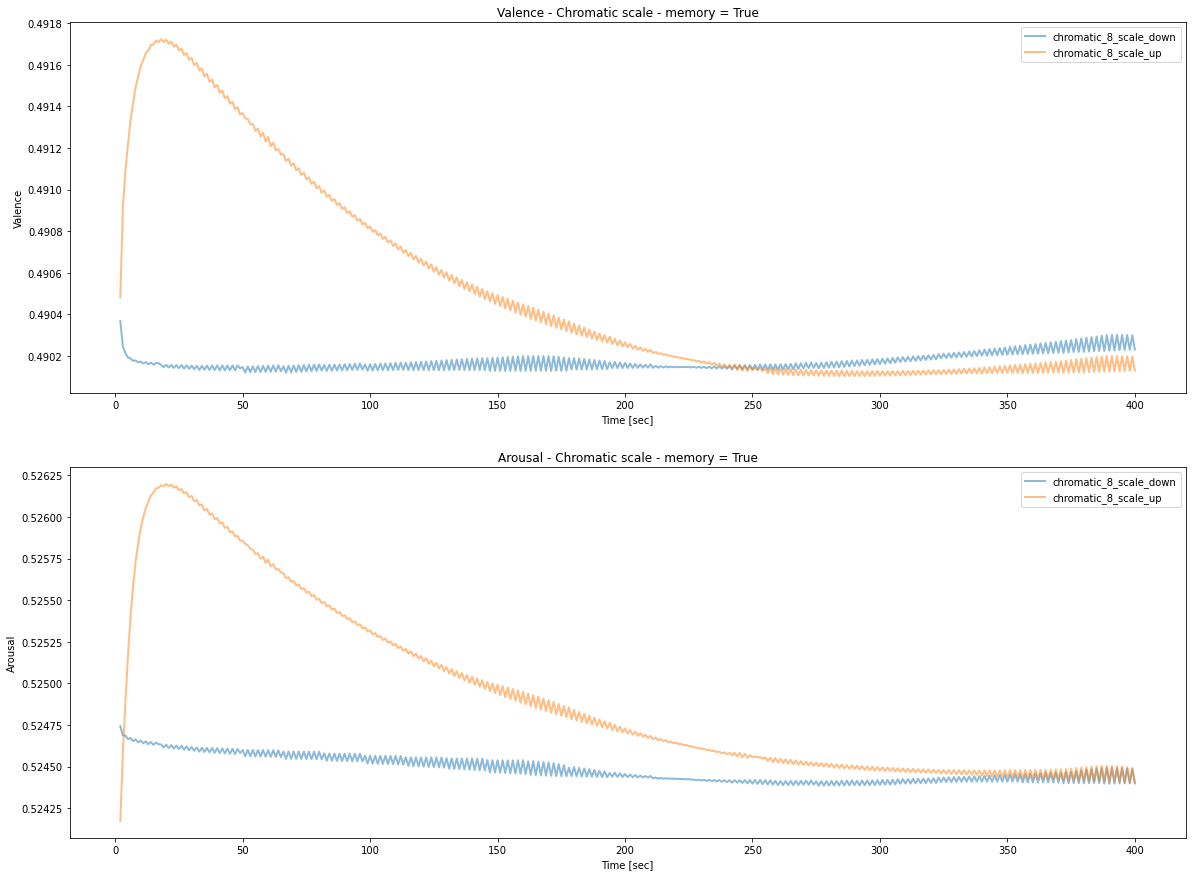

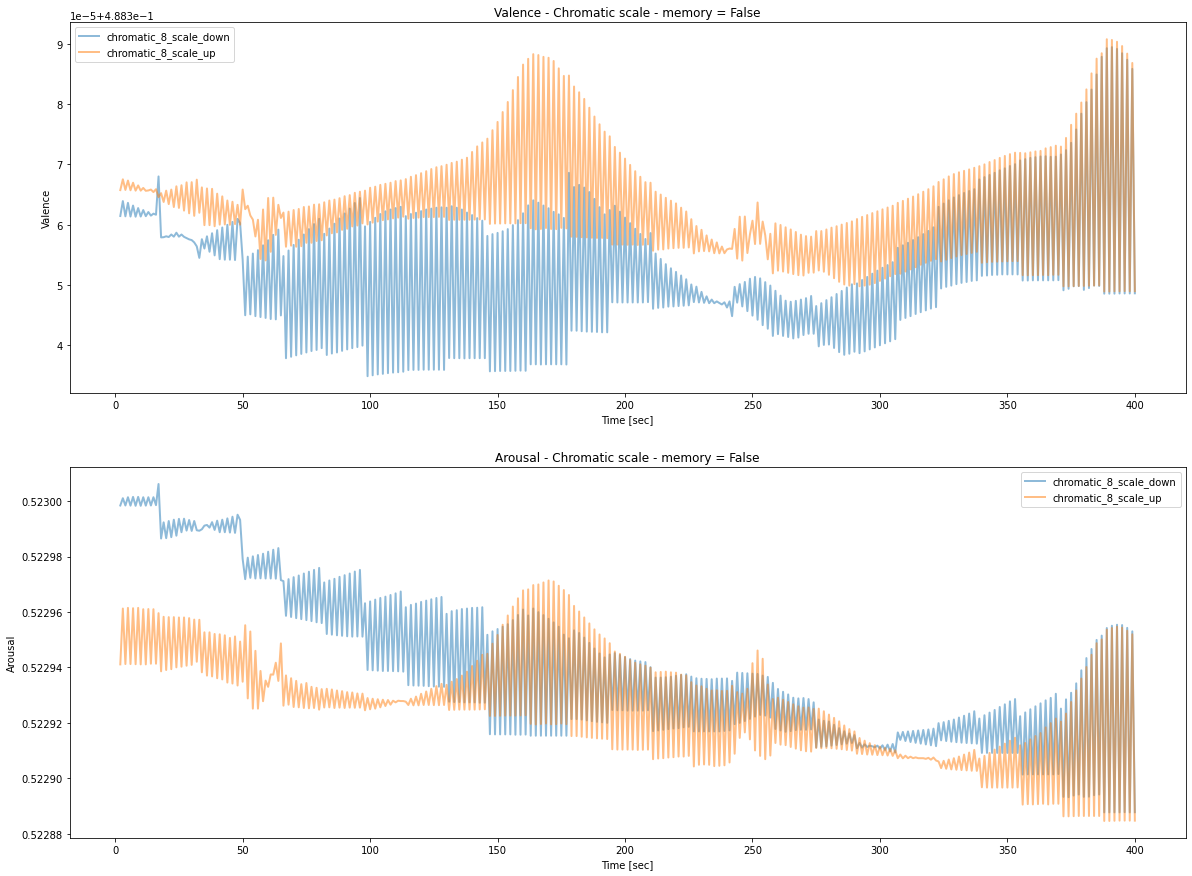

In [95]:
full_length = max([len(v[True][1]) for k, v in scale_down_results.items()])

for use_memory in [True, False]:
    all_results = [(file_name, results[use_memory][0], results[use_memory][1]) for file_name, results in scale_down_results.items()]
    all_results += [(file_name, results[use_memory][0], results[use_memory][1]) for file_name, results in scale_up_results.items()]
    plot_thayer_model([v[1] + [None]*(full_length - len(v[1])) for v in all_results], 
                      [v[2] + [None]*(full_length - len(v[2])) for v in all_results], 
                      f"Chromatic scale - memory = {str(use_memory)}",
                      [v[0] for v in all_results])

<hr>
<hr>
<hr>

#### Continuous A-C

In [104]:
one_tone_A_spectograms = get_spectograms("Harmony_A_C_one_tone.wav")

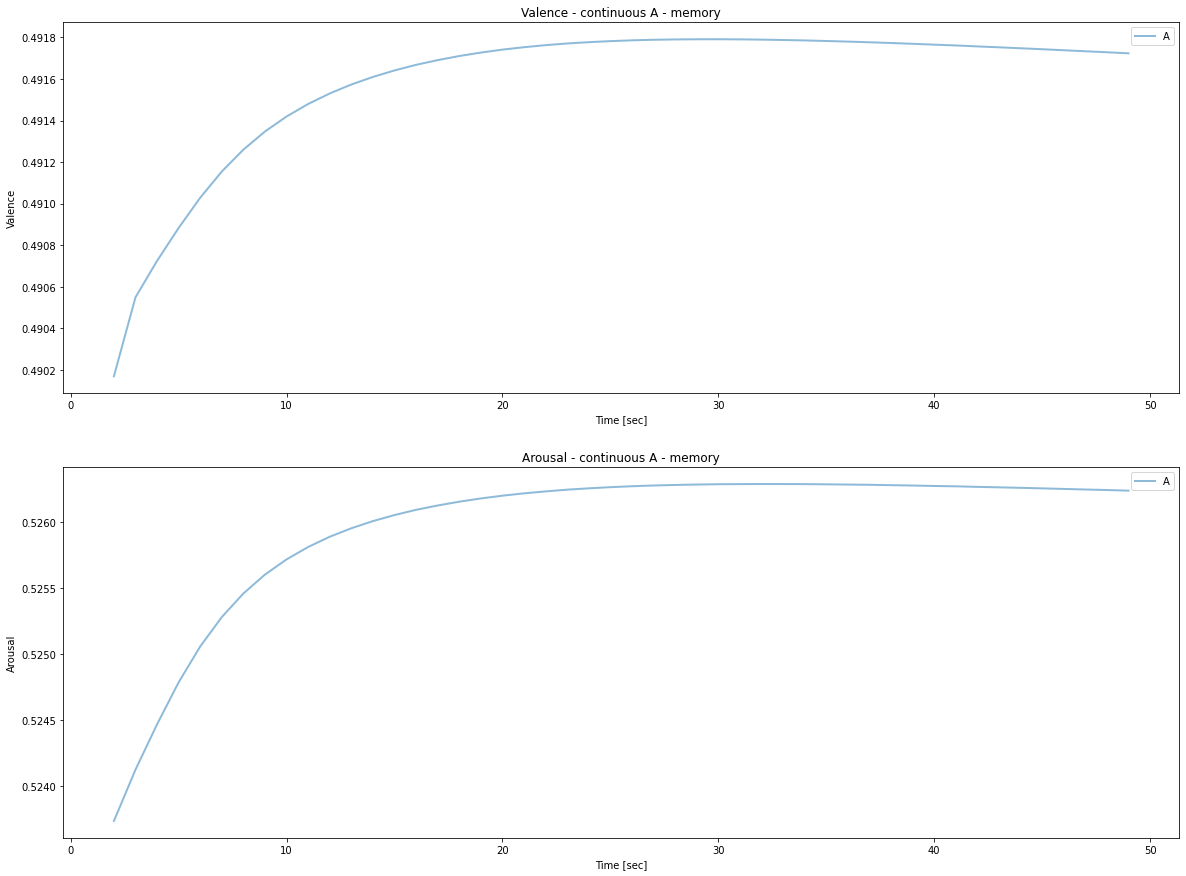

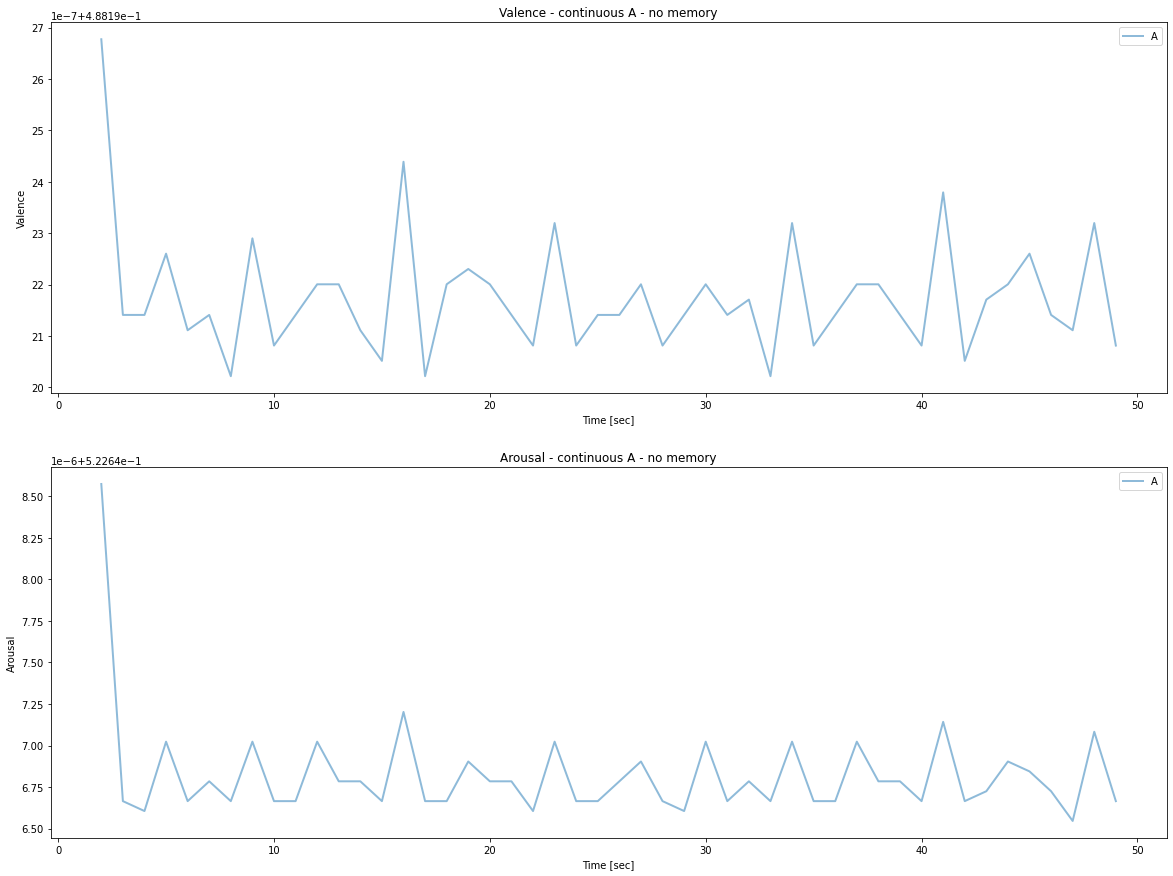

In [106]:
valence_values, arousal_values = test_spectrograms(one_tone_A_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous A - memory", ['A'])
valence_values, arousal_values = test_spectrograms(one_tone_A_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous A - no memory", ['A'])

#### Continuous A-C#

In [107]:
one_tone_C_spectograms = get_spectograms("Harmony_A_Cs_one_tone.wav")

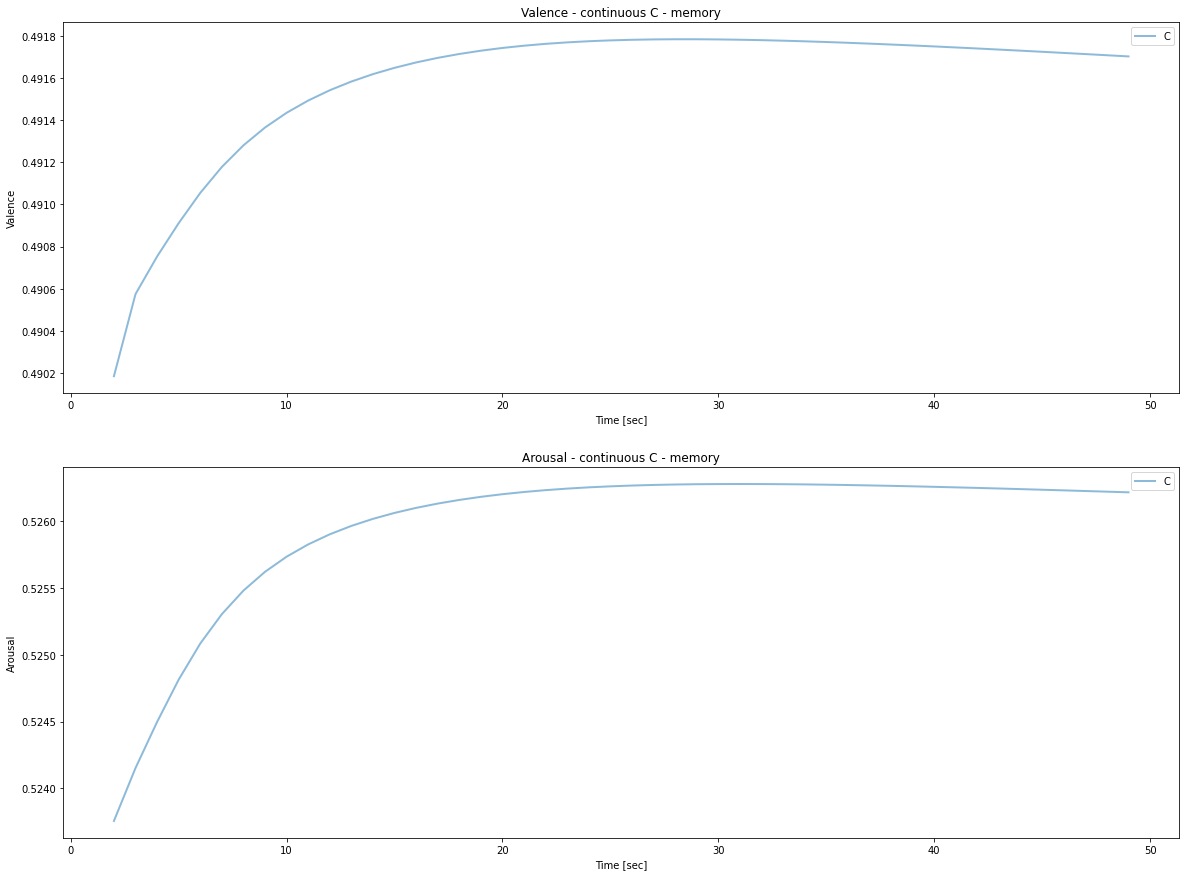

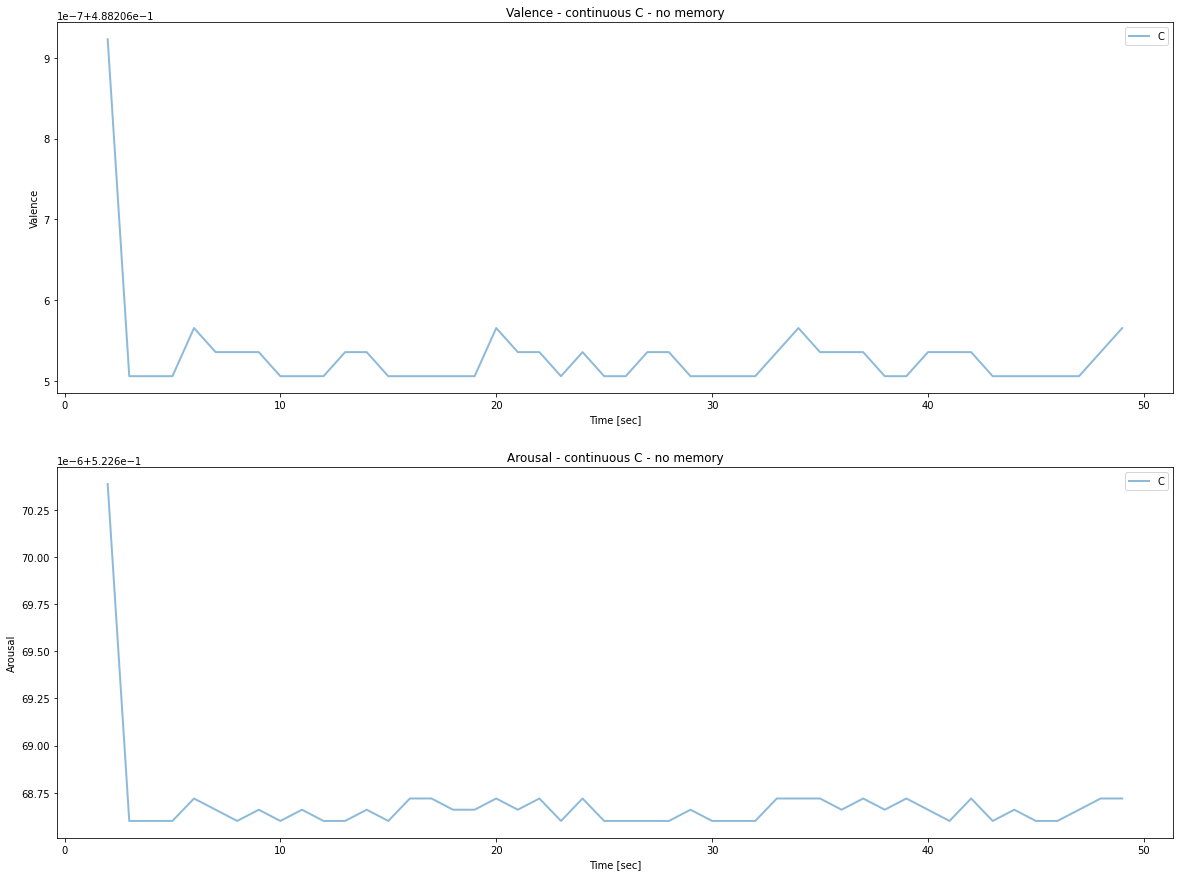

In [108]:
valence_values, arousal_values = test_spectrograms(one_tone_C_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous C - memory", ['C'])
valence_values, arousal_values = test_spectrograms(one_tone_C_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous C - no memory", ['C'])

#### A-C 120 bpm

In [109]:
one_tone_A_120_bpm_spectograms = get_spectograms("Harmony_A_C_120_bpm.wav")

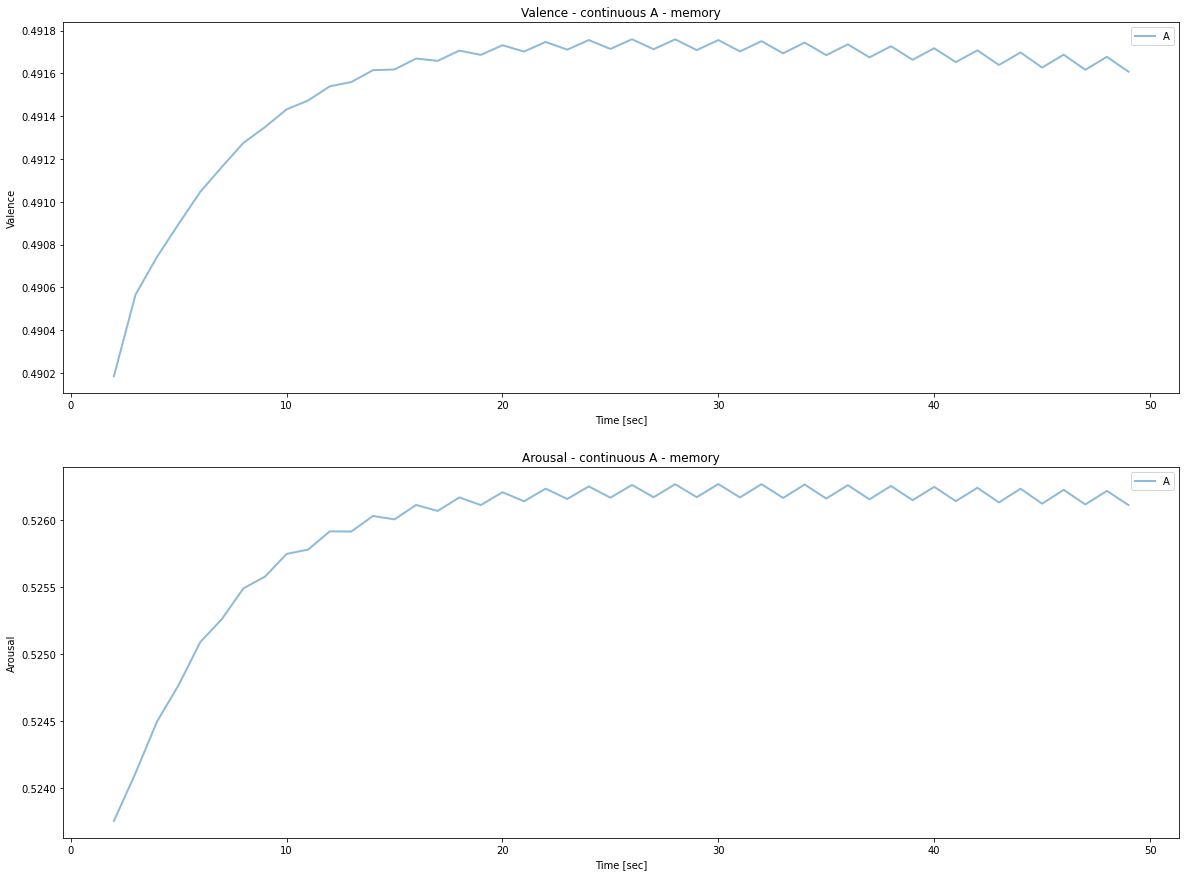

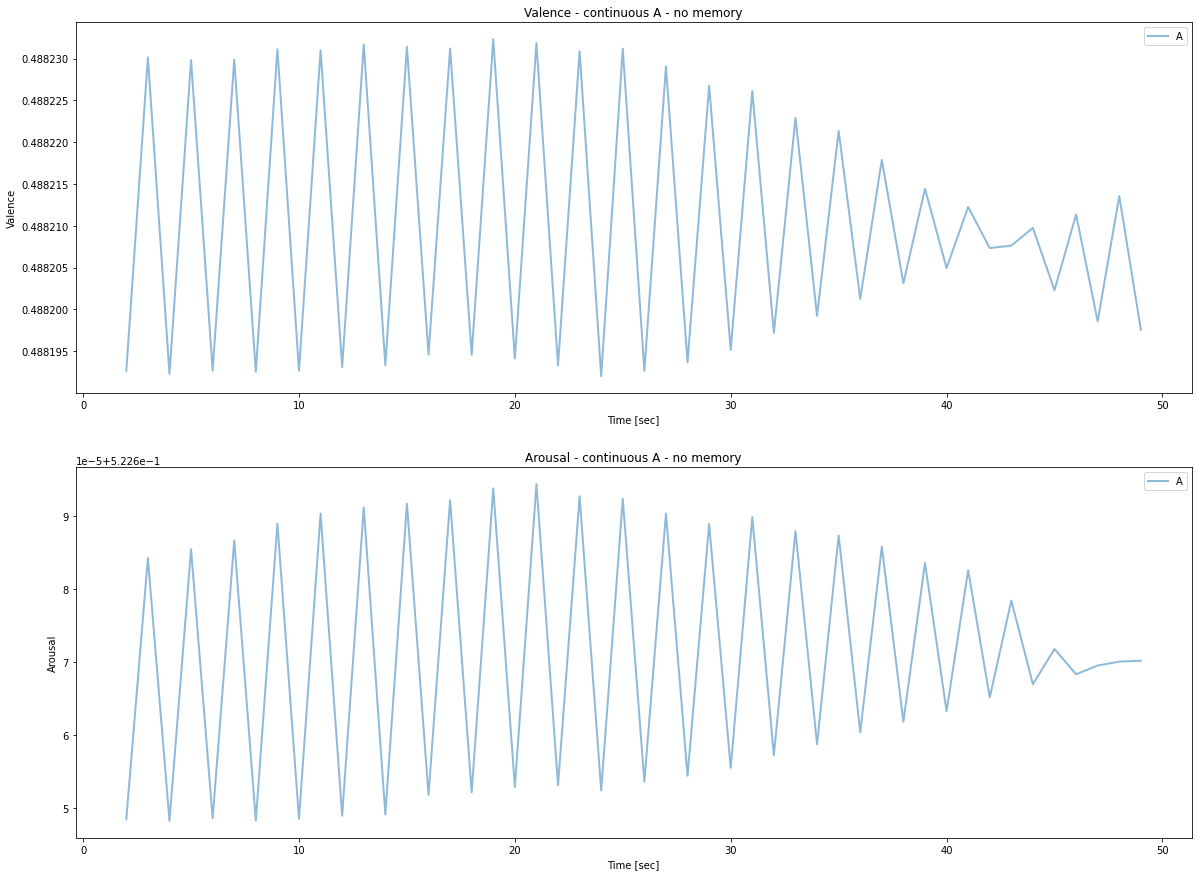

In [110]:
valence_values, arousal_values = test_spectrograms(one_tone_A_120_bpm_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous A - memory", ['A'])
valence_values, arousal_values = test_spectrograms(one_tone_A_120_bpm_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous A - no memory", ['A'])

#### A-C# 120 bpm

In [111]:
one_tone_C_120_bpm_spectograms = get_spectograms("Harmony_A_Cs_120_bpm.wav")

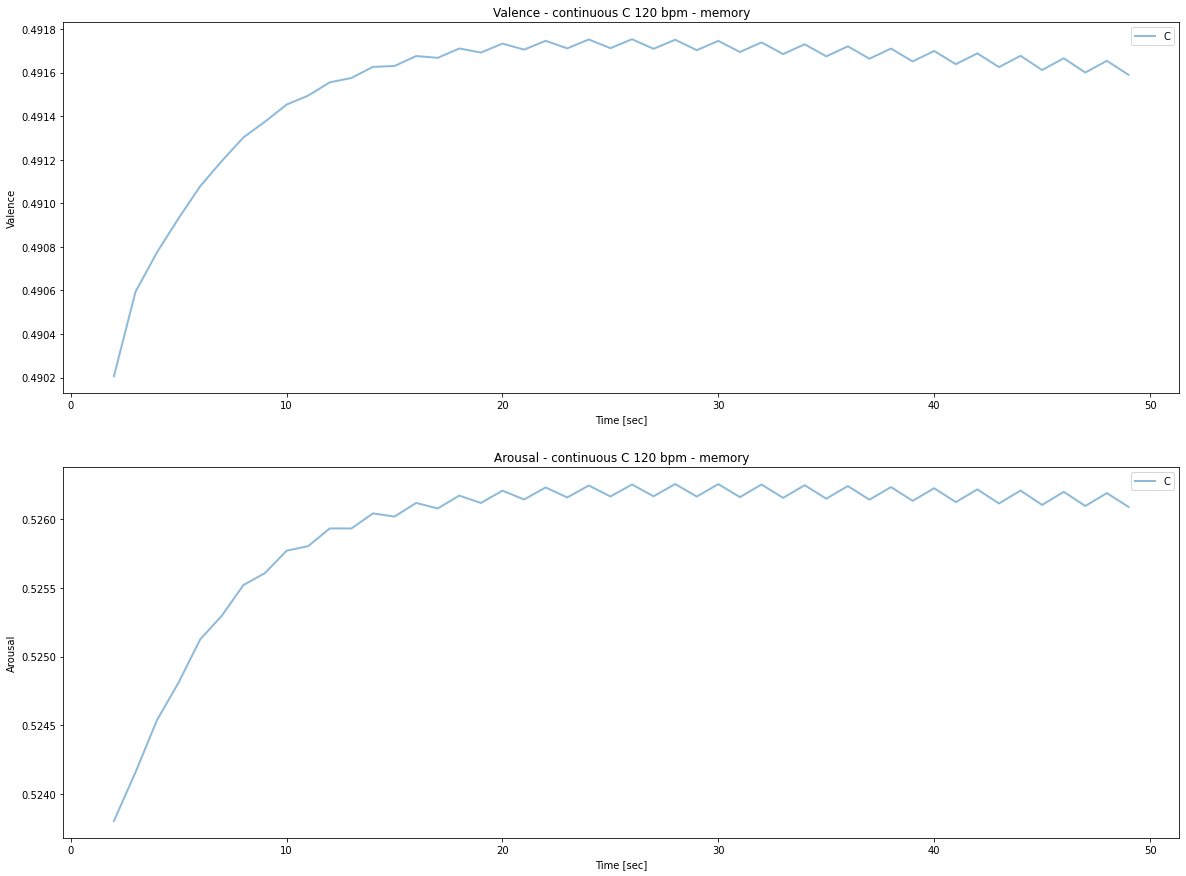

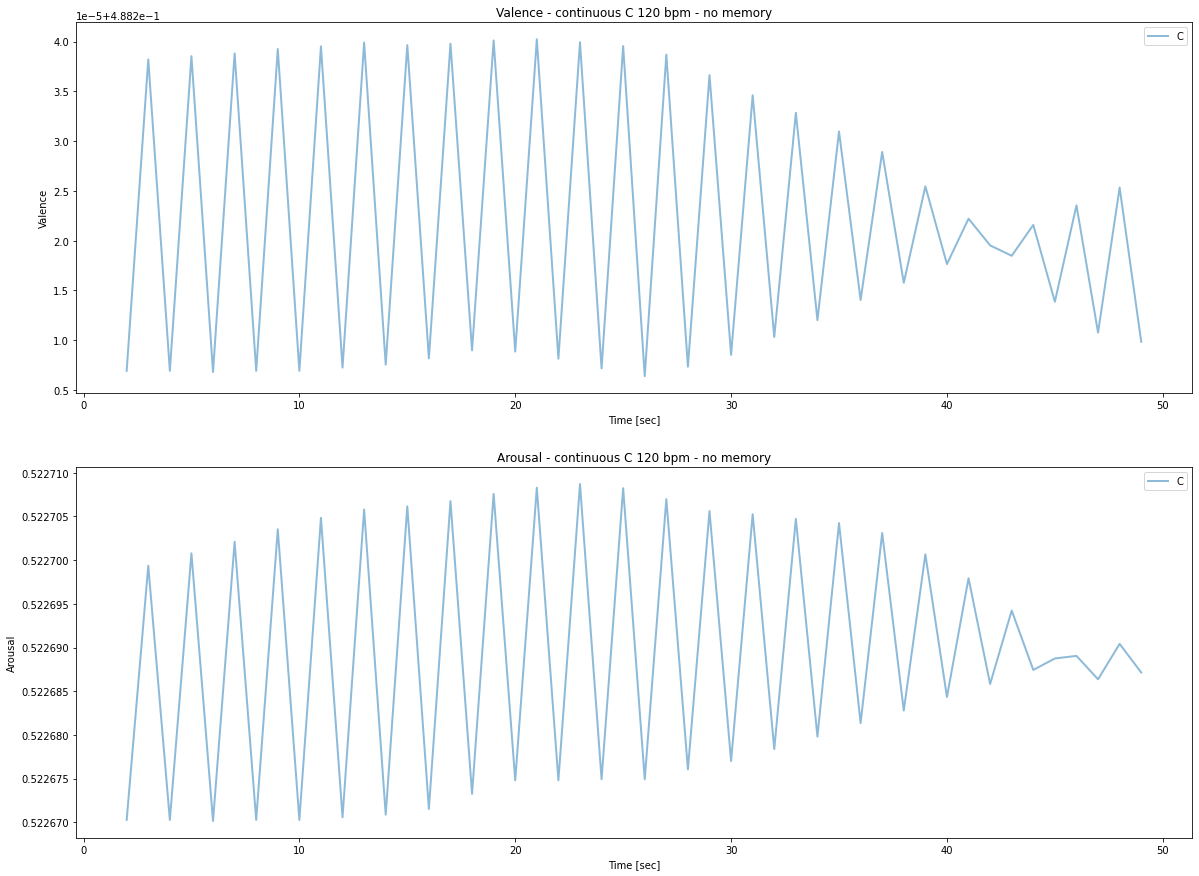

In [112]:
valence_values, arousal_values = test_spectrograms(one_tone_C_120_bpm_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous C 120 bpm - memory", ['C'])
valence_values, arousal_values = test_spectrograms(one_tone_C_120_bpm_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous C 120 bpm - no memory", ['C'])

<hr><hr><hr>

#### One tone A

In [96]:
one_tone_A_spectograms = get_spectograms("one_tone_A.wav")

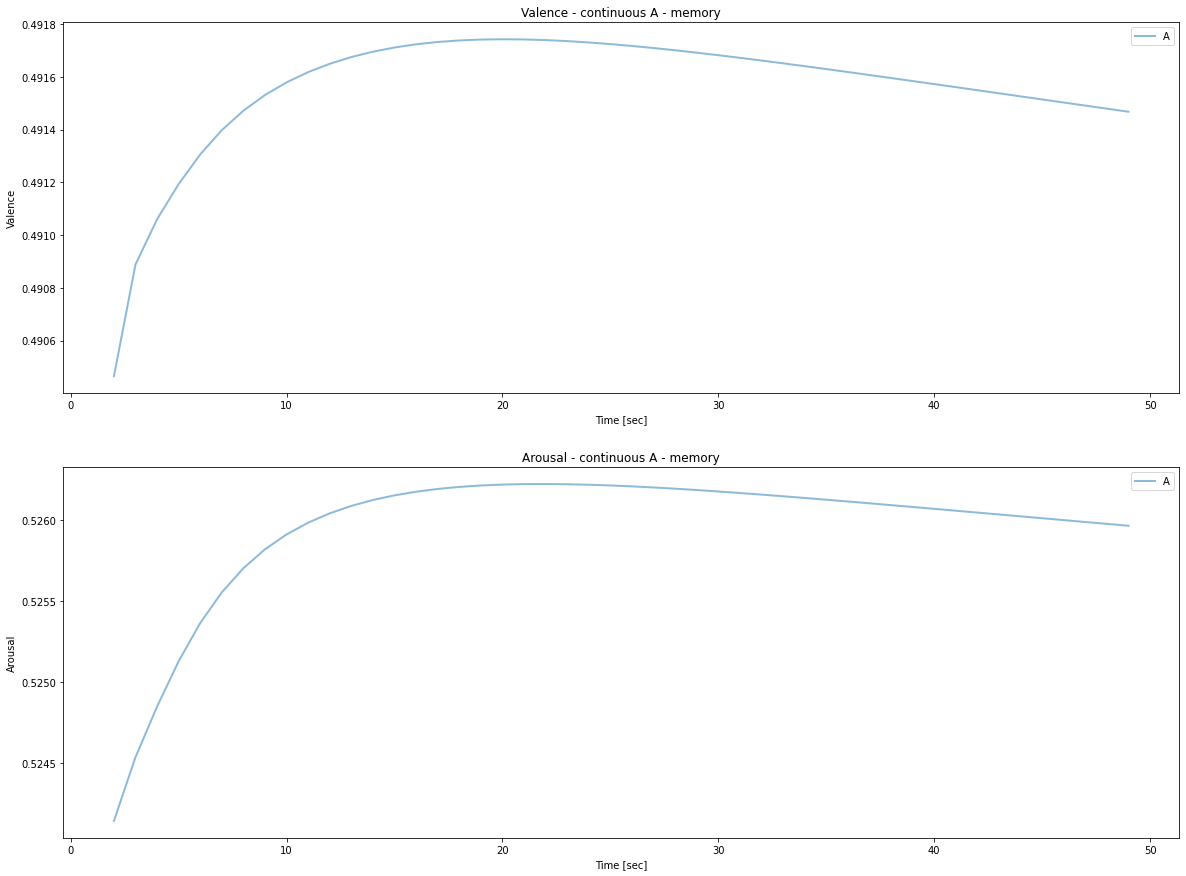

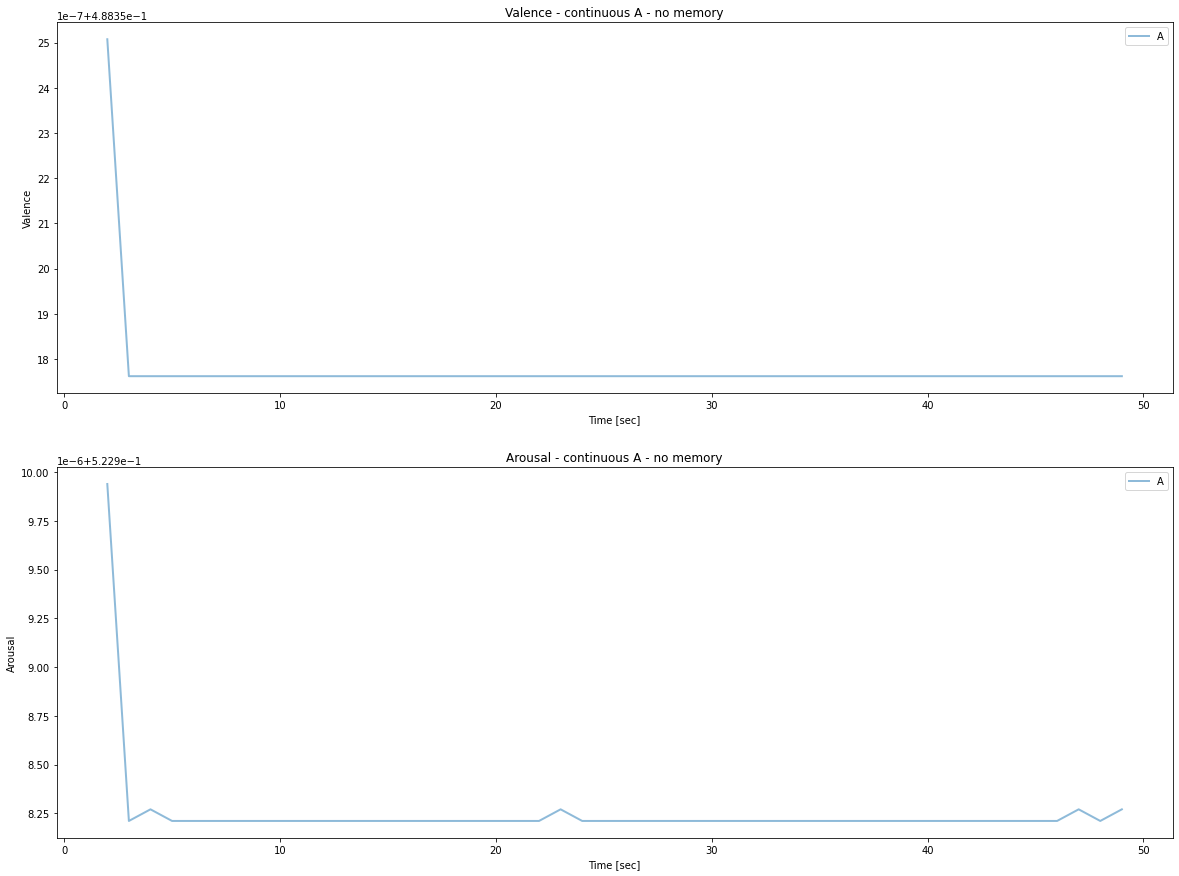

In [97]:
valence_values, arousal_values = test_spectrograms(one_tone_A_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous A - memory", ['A'])
valence_values, arousal_values = test_spectrograms(one_tone_A_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous A - no memory", ['A'])

#### One tone C

In [98]:
one_tone_C_spectograms = get_spectograms("one_tone_C.wav")

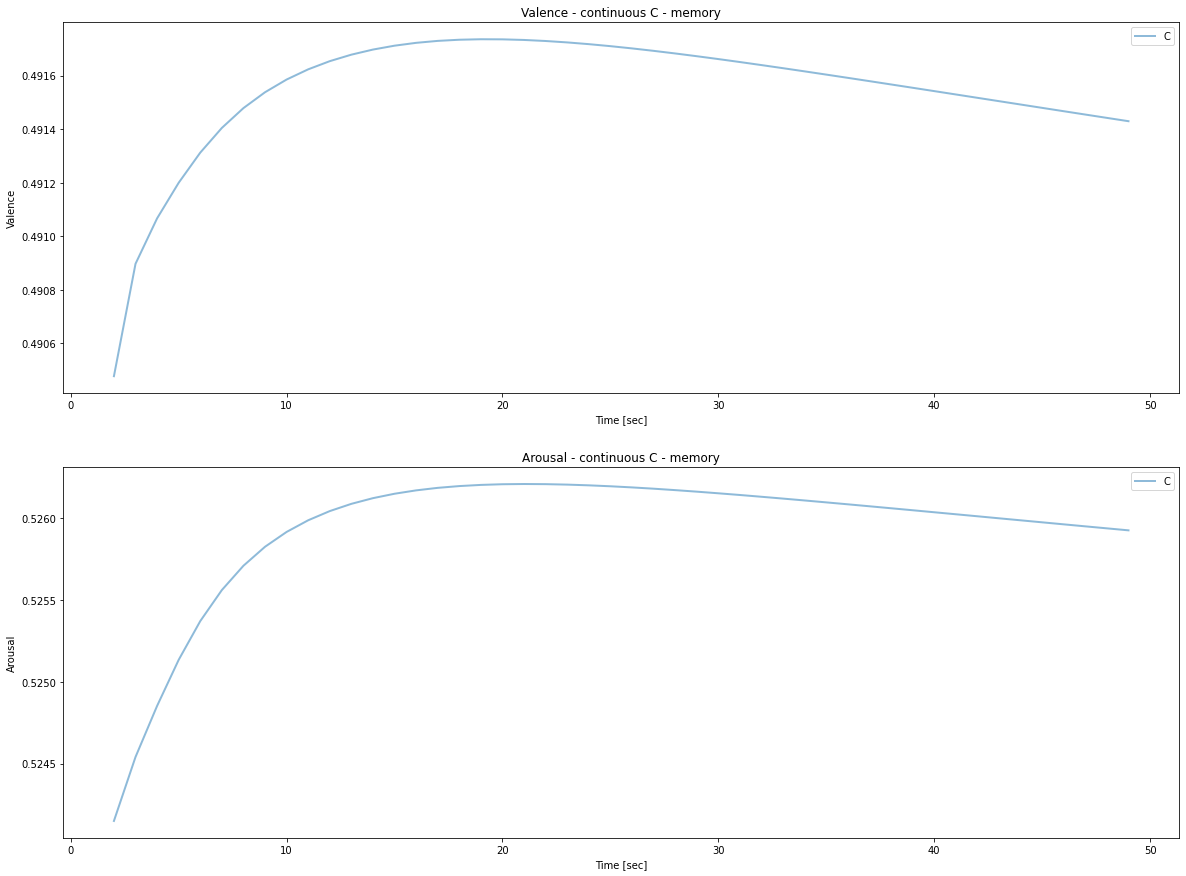

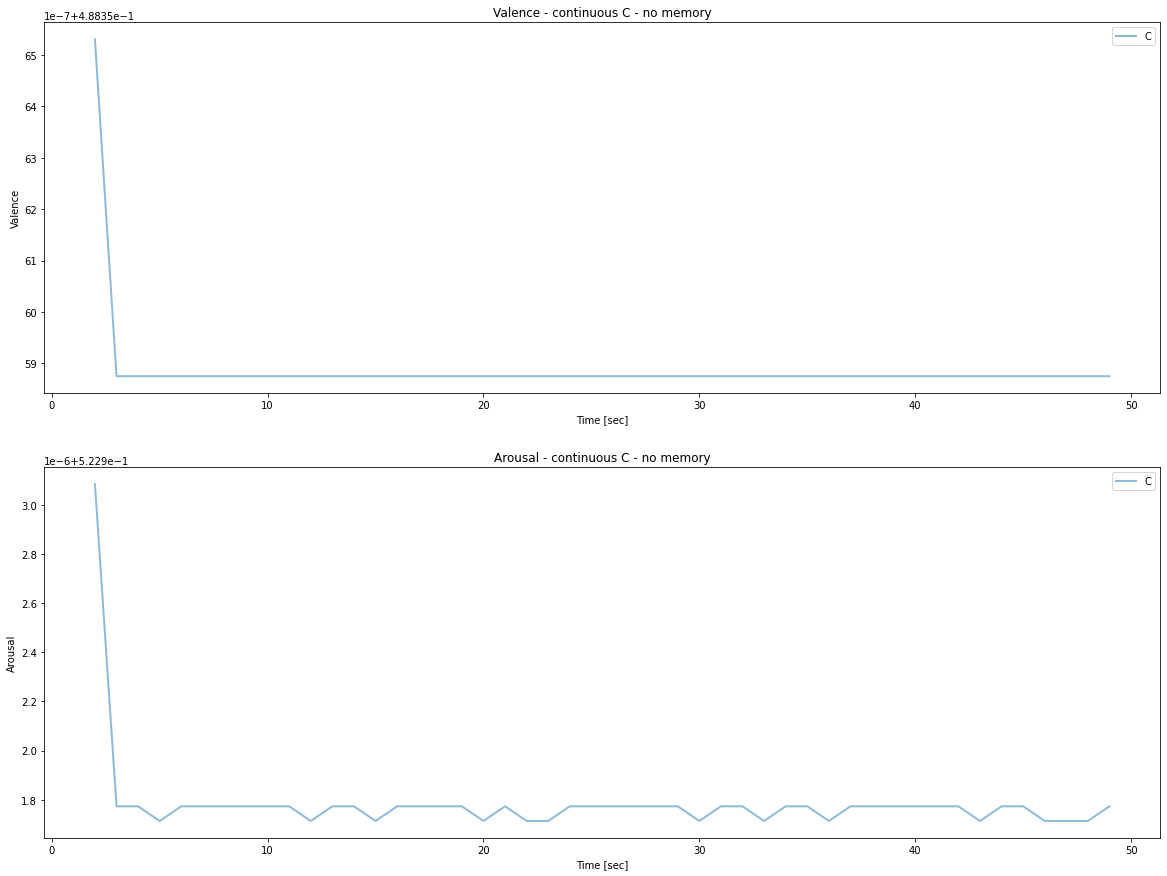

In [99]:
valence_values, arousal_values = test_spectrograms(one_tone_C_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous C - memory", ['C'])
valence_values, arousal_values = test_spectrograms(one_tone_C_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous C - no memory", ['C'])

#### One tone A - 120 bpm

In [100]:
one_tone_A_120_bpm_spectograms = get_spectograms("one_tone_A_120_bpm.wav")

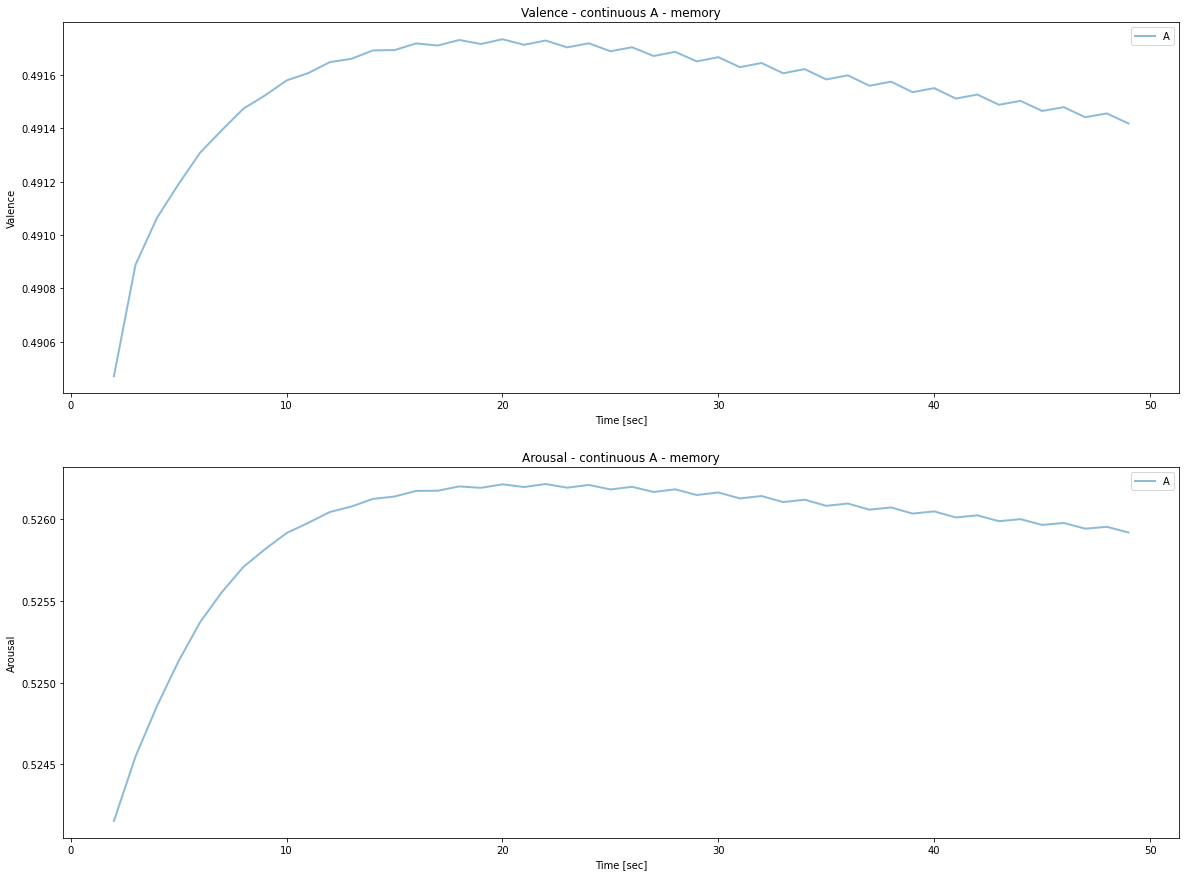

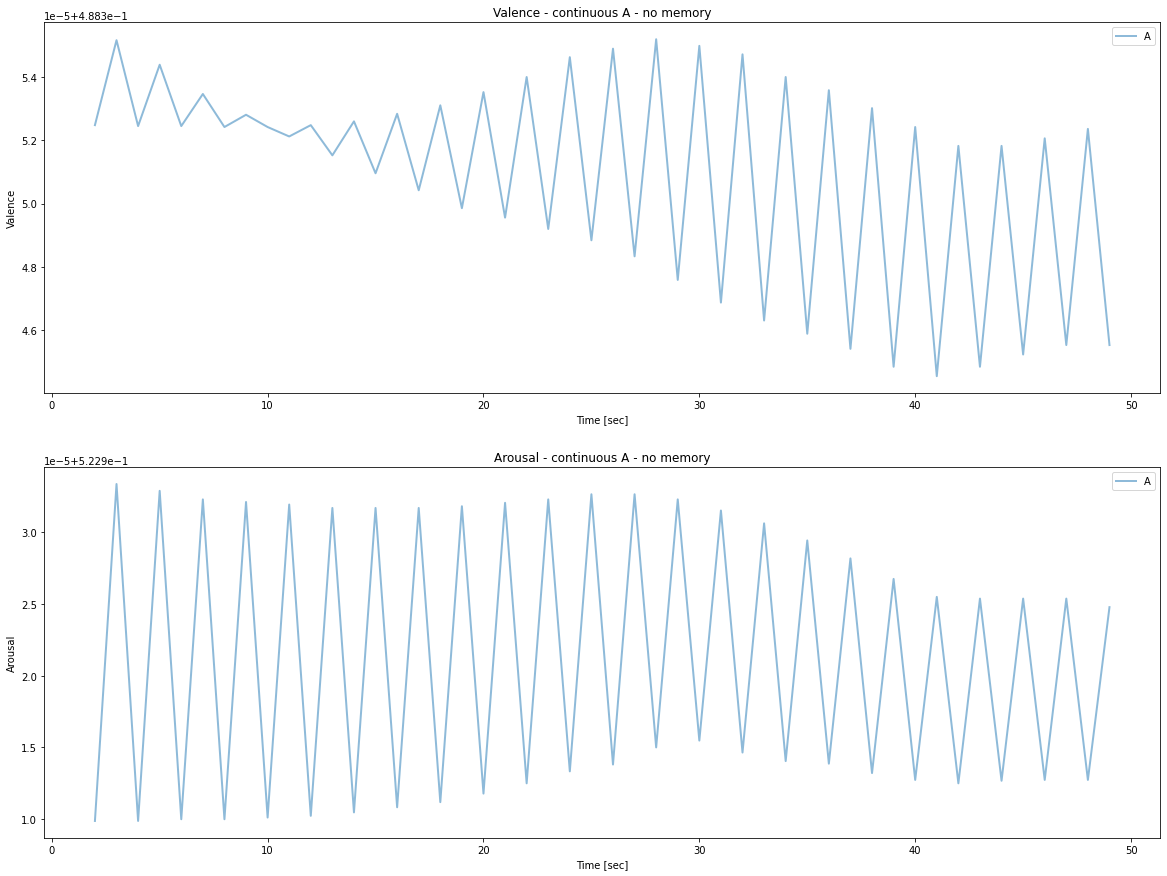

In [101]:
valence_values, arousal_values = test_spectrograms(one_tone_A_120_bpm_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous A - memory", ['A'])
valence_values, arousal_values = test_spectrograms(one_tone_A_120_bpm_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous A - no memory", ['A'])

#### One tone C - 120 bpm

In [102]:
one_tone_C_120_bpm_spectograms = get_spectograms("one_tone_C_120_bpm.wav")

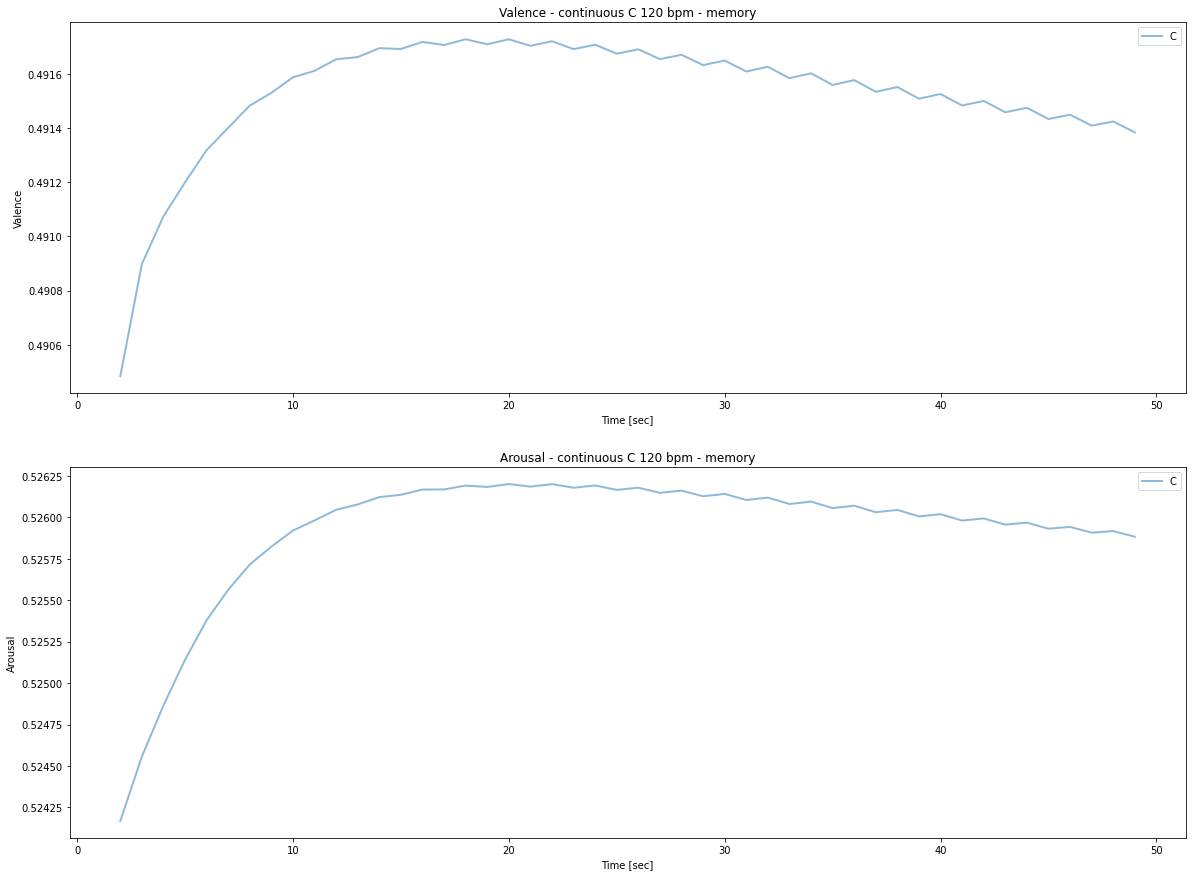

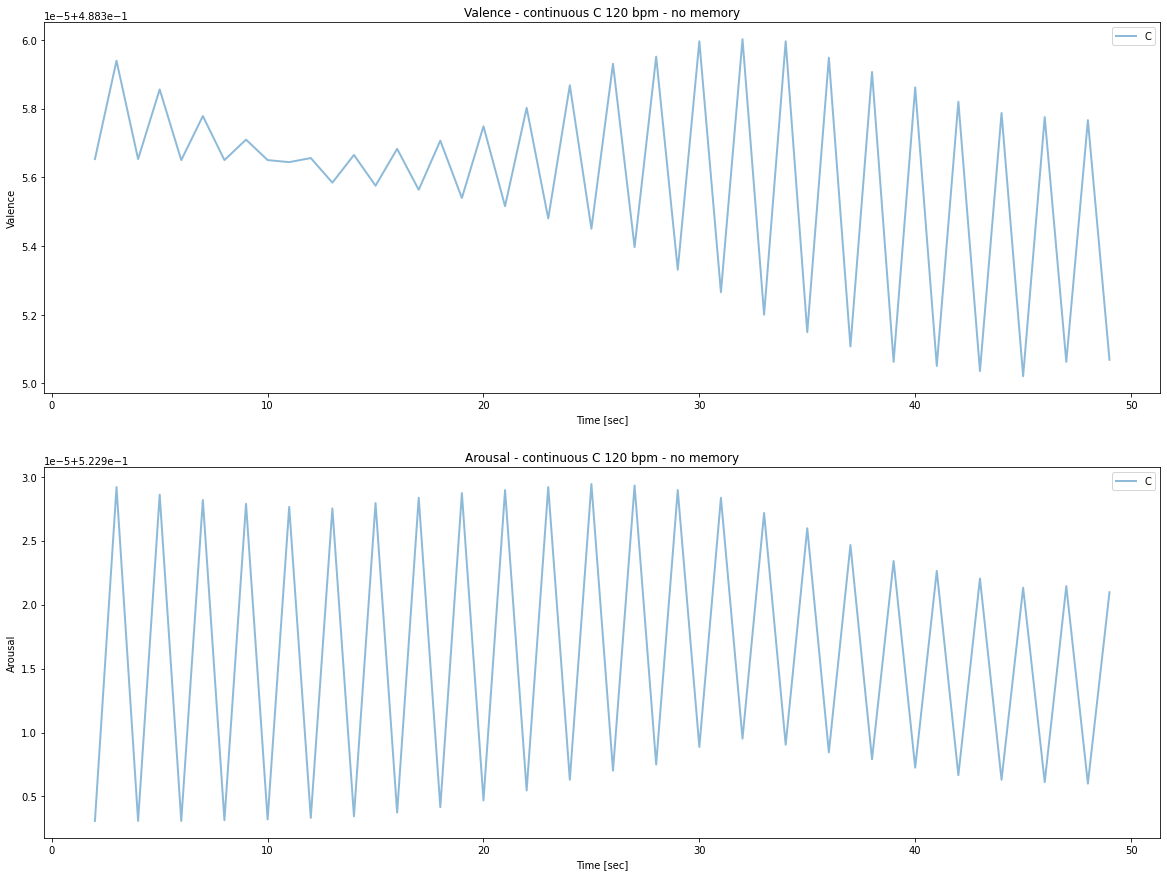

In [103]:
valence_values, arousal_values = test_spectrograms(one_tone_C_120_bpm_spectograms, use_memory=True)
plot_thayer_model([valence_values], [arousal_values], "continuous C 120 bpm - memory", ['C'])
valence_values, arousal_values = test_spectrograms(one_tone_C_120_bpm_spectograms, use_memory=False)
plot_thayer_model([valence_values], [arousal_values], "continuous C 120 bpm - no memory", ['C'])